In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from sklearn.metrics import mean_squared_error
import math
from numpy.core.memmap import uint8
import sys

In [ ]:
img = cv2.imread("Camera Man.bmp", 0)

In [ ]:
@jit(nopython=True)
def histogram(image):
  R, C = image.shape

  histogram_array = np.zeros(256)

  for r in range (R):
    for c in range (C):
      histogram_array[int(image[r][c]) - 1] += 1
  
  return histogram_array

Text(0.5, 1.0, 'Histogram: Original')

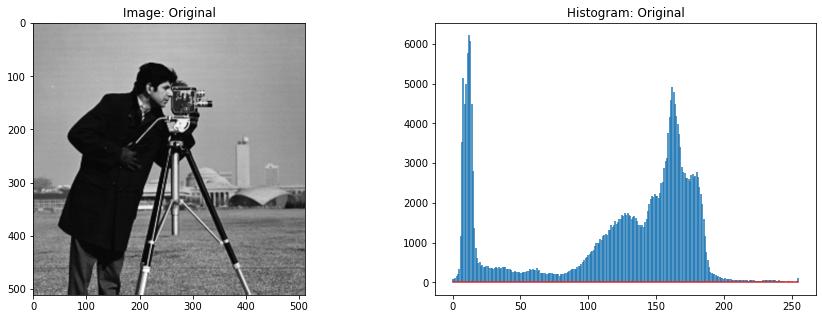

In [ ]:
# 2.1.1
fig, plot = plt.subplots(1, 2, figsize = (15, 5))

plot[0].imshow(img, cmap='gray')
plot[0].set_title("Image: Original")

plot[1].stem(histogram(img), markerfmt=' ', use_line_collection=True)
plot[1].set_title("Histogram: Original")

In [ ]:
# @jit(nopython=True)
def contrast_brightness(image, darken, intensity):
  change_brightness_value = intensity

  if darken:
    change_brightness_value = 1 / change_brightness_value

  R, C = image.shape
  brightness_changed_image = np.zeros((R, C))

  for r in range (R):
    for c in range (C):
      brightness_changed_image[r][c] = image[r][c] * change_brightness_value

  return brightness_changed_image.astype(uint8)

Text(0.5, 1.0, 'Image: Contrast Changed')

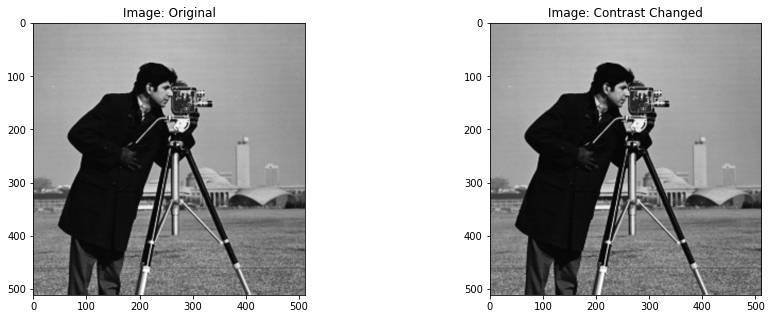

In [ ]:
# 2.1.1.1
fig, plot = plt.subplots(1, 2, figsize = (15, 5))

plot[0].imshow(img, cmap='gray')
plot[0].set_title("Image: Original")

D = contrast_brightness(img, True, 3)

plot[1].imshow(D, cmap='gray', vmin=np.min(D), vmax=np.max(D))
plot[1].set_title("Image: Contrast Changed")

Text(0.5, 1.0, 'Image: Contrast Changed')

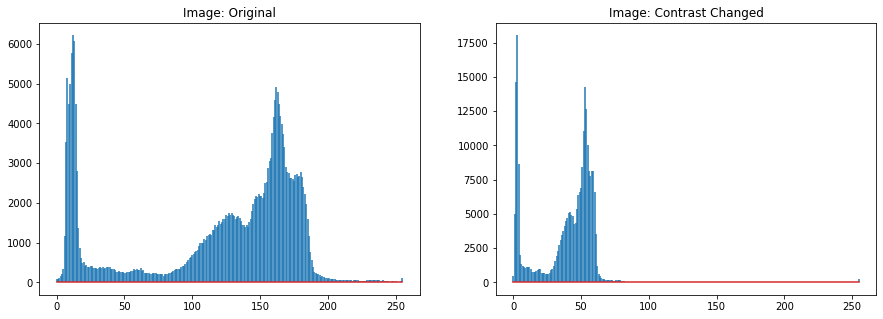

In [ ]:
# 2.1.1.2
fig, plot = plt.subplots(1, 2, figsize = (15, 5))

plot[0].stem(histogram(img), markerfmt=' ', use_line_collection=True)
plot[0].set_title("Image: Original")

plot[1].stem(histogram(D), markerfmt=' ', use_line_collection=True)
plot[1].set_title("Image: Contrast Changed")

In [ ]:
@jit(nopython=True)
def histogram_equalization(image, local=False):
  R, C = image.shape
  size = R * C
  histogram_arr = histogram(image)
  equalized_histogram = np.zeros(256)
  equalized_image = np.zeros((R,C))

  max_value = 255

  if local:
    max_value = image.max()

  curr_cdf = 0
  for index in range (256):
    curr_cdf += histogram_arr[index] / size
    equalized_histogram[index] = int(max_value * curr_cdf)

  for r in range (R):
    for c in range (C):
      equalized_image[r][c] = equalized_histogram[int(image[r][c])]

  return equalized_image

MSE Between My Function and Library's Function = 60.741981506347656


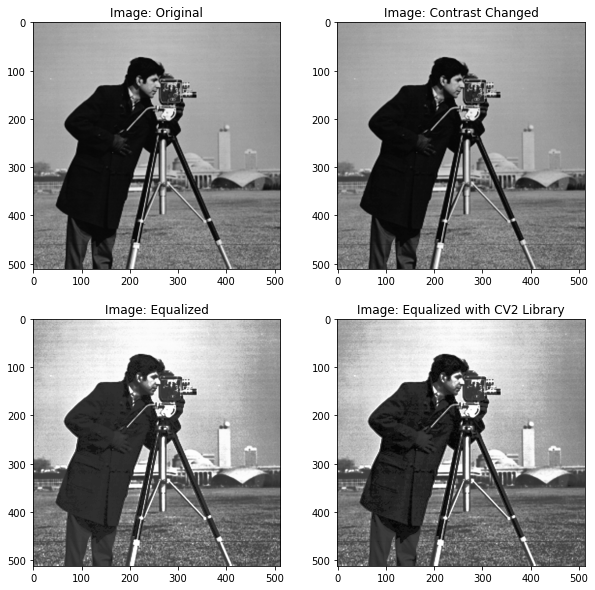

In [ ]:
# 2.1.1.3
fig, plot = plt.subplots(2, 2, figsize = (10, 10))

plot[0][0].imshow(img, cmap='gray')
plot[0][0].set_title("Image: Original")

plot[0][1].imshow(D, cmap='gray', vmin=np.min(D), vmax=np.max(D))
plot[0][1].set_title("Image: Contrast Changed")

H = histogram_equalization(D)

plot[1][0].imshow(H, cmap='gray')
plot[1][0].set_title("Image: Equalized")

H_with_library = cv2.equalizeHist(D)

plot[1][1].imshow(H_with_library, cmap='gray')
plot[1][1].set_title("Image: Equalized with CV2 Library")

print("MSE Between My Function and Library's Function = " + str(mean_squared_error(H, H_with_library)))

In [ ]:
@jit(nopython=True)
def local_histogram_equalization(image, mask, local):
  R, C = image.shape

  local_equalized_image = np.zeros((R, C))

  for r in range (0, R, mask):
    for c in range (0, C, mask):
      local_equalized_image[r:r + mask, c:c + mask] = histogram_equalization(image[r:r + mask, c:c + mask], local)

  return local_equalized_image

In [ ]:
# 2.1.1.4
fig, plot_r1 = plt.subplots(1, 3, figsize = (15, 5))

plot_r1[0].imshow(img, cmap='gray')
plot_r1[0].set_title("Image: Original")

plot_r1[1].imshow(D, cmap='gray')
plot_r1[1].set_title("Image: Contrast Changed")

plot_r1[2].imshow(H, cmap='gray')
plot_r1[2].set_title("Image: Equalized")

masks = [256, 128, 64, 32, 16, 8, 4, 2]

L_without_max_arr = np.zeros((len(masks), 512, 512))
L_with_max_arr = np.zeros((len(masks), 512, 512))

mse_without_max_arr = np.zeros(len(masks))
mse_with_max_arr = np.zeros(len(masks))

fig, plot_r2 = plt.subplots(4, int(len(masks) / 2), figsize = (20, 22))

for mask_index in range (int(len(masks) / 2)):
  for subplot_row in range (2):
    L_without_max = local_histogram_equalization(D, masks[mask_index + 4 * subplot_row], False)
    L_with_max = local_histogram_equalization(D, masks[mask_index + 4 * subplot_row], True)

    mse_without_max_arr[mask_index + 4 * subplot_row] = mean_squared_error(D, L_without_max)
    mse_with_max_arr[mask_index + 4 * subplot_row] = mean_squared_error(D, L_with_max)

    plot_r2[subplot_row + 0][mask_index].imshow(L_without_max, cmap='gray')
    plot_r2[subplot_row + 0][mask_index].set_title("Image: Locally Equalized\n(no max & mask = " + str(masks[mask_index + 4 * subplot_row]) + " MSE = " + str(int(mse_without_max_arr[mask_index + 4 * subplot_row])) + ")")

    plot_r2[subplot_row + 2][mask_index].imshow(L_with_max, cmap='gray')
    plot_r2[subplot_row + 2][mask_index].set_title("Image: Locally Equalized\n(max & mask = " + str(masks[mask_index + 4 * subplot_row]) + " MSE = " + str(int(mse_with_max_arr[mask_index + 4 * subplot_row])) + ")")

    L_without_max_arr[mask_index + 4 * subplot_row, 0:512, 0:512] = L_without_max
    L_with_max_arr[mask_index + 4 * subplot_row, 0:512, 0:512] = L_with_max

Output hidden; open in https://colab.research.google.com to view.

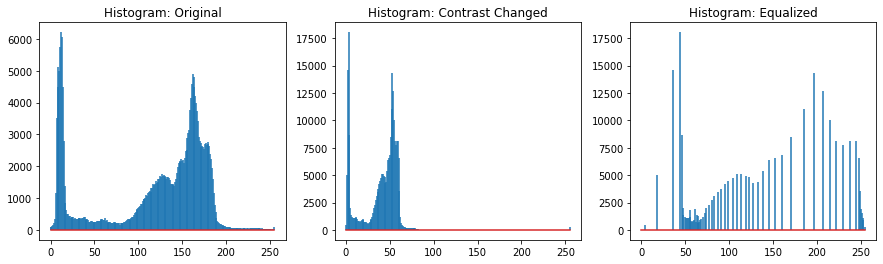

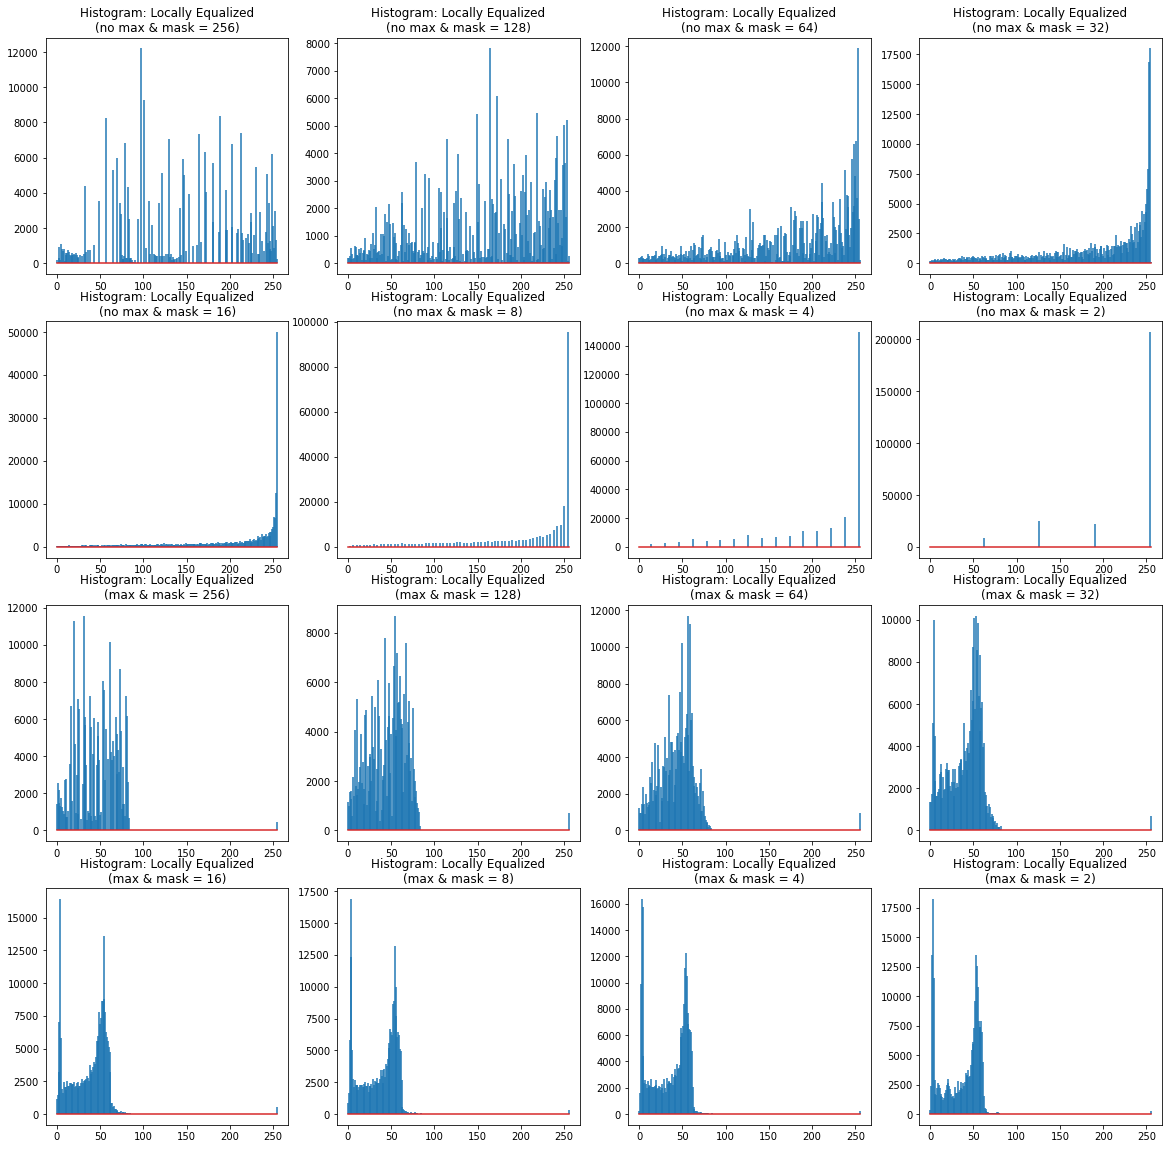

In [ ]:
# 2.1.1.5
fig, plot_r1 = plt.subplots(1, 3, figsize = (15, 4))

plot_r1[0].stem(histogram(img), markerfmt=' ', use_line_collection=True)
plot_r1[0].set_title("Histogram: Original")

plot_r1[1].stem(histogram(D), markerfmt=' ', use_line_collection=True)
plot_r1[1].set_title("Histogram: Contrast Changed")

plot_r1[2].stem(histogram(H), markerfmt=' ', use_line_collection=True)
plot_r1[2].set_title("Histogram: Equalized")

fig, plot_r2 = plt.subplots(4, int(len(masks) / 2), figsize = (20, 20))

for mask_index in range (int(len(masks) / 2)):
  for subplot_row in range (2):
    plot_r2[subplot_row + 0][mask_index].stem(histogram(L_without_max_arr[mask_index + 4 * subplot_row, 0:512, 0:512]), markerfmt=' ', use_line_collection=True)
    plot_r2[subplot_row + 0][mask_index].set_title("Histogram: Locally Equalized\n(no max & mask = " + str(masks[mask_index + 4 * subplot_row]) + ")")

    plot_r2[subplot_row + 2][mask_index].stem(histogram(L_with_max_arr[mask_index + 4 * subplot_row, 0:512, 0:512]), markerfmt=' ', use_line_collection=True)
    plot_r2[subplot_row + 2][mask_index].set_title("Histogram: Locally Equalized\n(max & mask = " + str(masks[mask_index + 4 * subplot_row]) + ")")

In [ ]:
@jit(nopython=True)
def log_transform_image_enhancement(image):
  c = 255 / np.log(1 + np.max(image))
  log_transformed_image = c * (np.log(image + 1))
  
  return log_transformed_image.astype(uint8)

In [ ]:
@jit(nopython=True)
def inverse_log_transform_image_enhancement(image):
  c = 255 / np.log(1 + np.max(image))
  inverse_log_transformed_image = np.exp(image) ** (1 / c)

  return inverse_log_transformed_image.astype(uint8)

In [ ]:
# @jit(nopython=True)
def power_law_transform_image_enhancement(image, gamma):
  power_law_transformed_image = np.array(255*(img / 255) ** gamma)
  
  return power_law_transformed_image.astype(uint8)

Text(0.5, 1.0, 'Image: Power Law Transformed (Gamma = 1.9)')

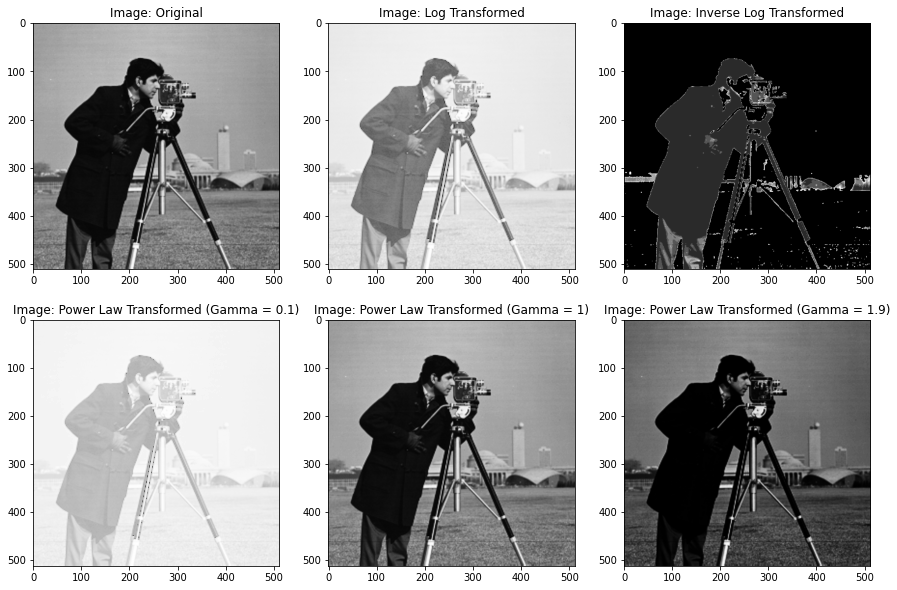

In [ ]:
# 2.1.1.6 - Images
fig, plot = plt.subplots(2, 3, figsize = (15, 10))

plot[0][0].imshow(img, cmap='gray')
plot[0][0].set_title("Image: Original")

plot[0][1].imshow(log_transform_image_enhancement(img), cmap='gray')
plot[0][1].set_title("Image: Log Transformed")

plot[0][2].imshow(inverse_log_transform_image_enhancement(img), cmap='gray')
plot[0][2].set_title("Image: Inverse Log Transformed")

plot[1][0].imshow(power_law_transform_image_enhancement(img, 0.1), cmap='gray')
plot[1][0].set_title("Image: Power Law Transformed (Gamma = 0.1)")

plot[1][1].imshow(power_law_transform_image_enhancement(img, 1), cmap='gray')
plot[1][1].set_title("Image: Power Law Transformed (Gamma = 1)")

plot[1][2].imshow(power_law_transform_image_enhancement(img, 1.9), cmap='gray')
plot[1][2].set_title("Image: Power Law Transformed (Gamma = 1.9)")

Text(0.5, 1.0, 'Histogram: Power Law Transformed (Gamma = 1.9)')

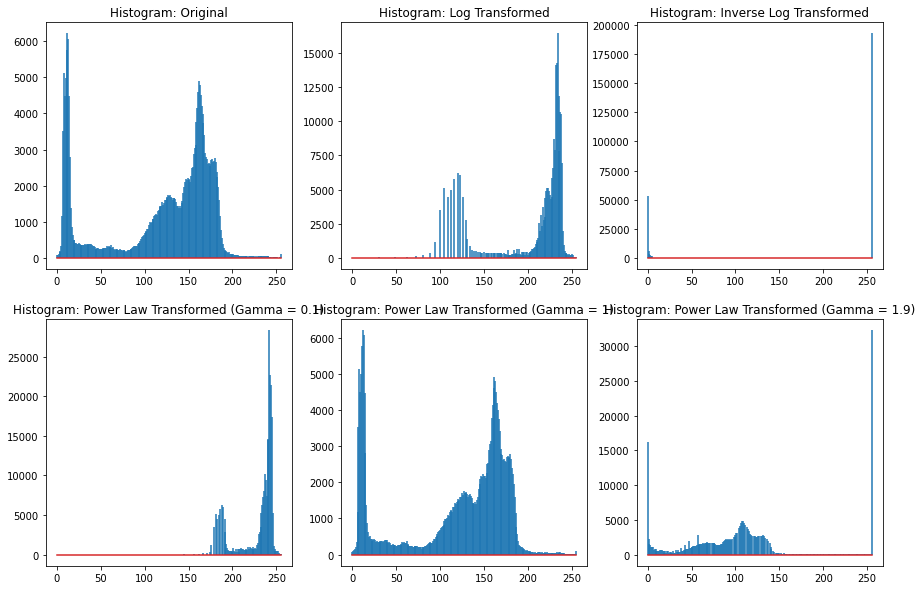

In [ ]:
# 2.1.1.6 - Histograms
fig, plot = plt.subplots(2, 3, figsize = (15, 10))

plot[0][0].stem(histogram(img), markerfmt=' ', use_line_collection=True)
plot[0][0].set_title("Histogram: Original")

plot[0][1].stem(histogram(log_transform_image_enhancement(img)), markerfmt=' ', use_line_collection=True)
plot[0][1].set_title("Histogram: Log Transformed")

plot[0][2].stem(histogram(inverse_log_transform_image_enhancement(img)), markerfmt=' ', use_line_collection=True)
plot[0][2].set_title("Histogram: Inverse Log Transformed")

plot[1][0].stem(histogram(power_law_transform_image_enhancement(img, 0.1)), markerfmt=' ', use_line_collection=True)
plot[1][0].set_title("Histogram: Power Law Transformed (Gamma = 0.1)")

plot[1][1].stem(histogram(power_law_transform_image_enhancement(img, 1)), markerfmt=' ', use_line_collection=True)
plot[1][1].set_title("Histogram: Power Law Transformed (Gamma = 1)")

plot[1][2].stem(histogram(power_law_transform_image_enhancement(img, 1.9)), markerfmt=' ', use_line_collection=True)
plot[1][2].set_title("Histogram: Power Law Transformed (Gamma = 1.9)")

Text(0.5, 1.0, 'Histogram: Equalized with CV2 Library')

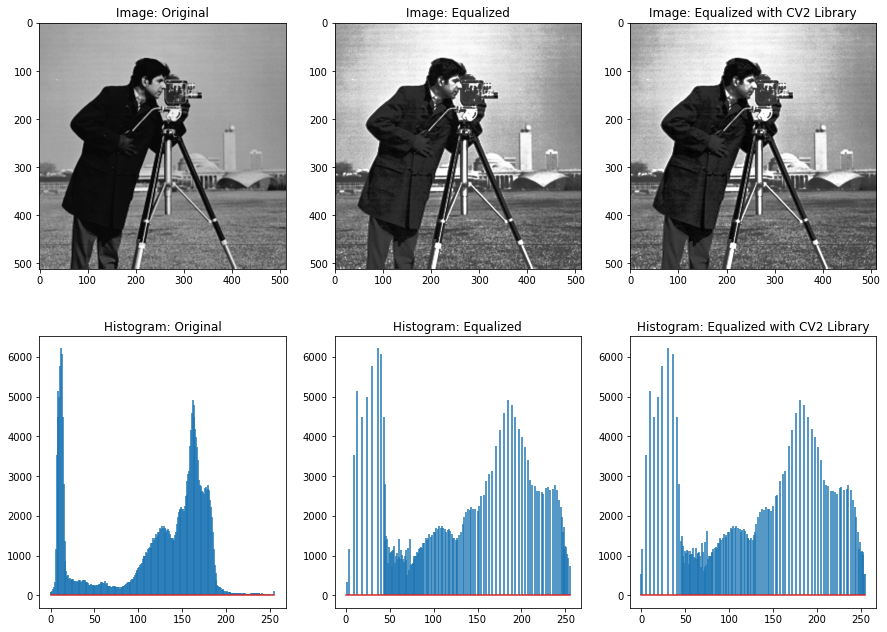

In [ ]:
# 2.1.2
fig, plot = plt.subplots(2, 3, figsize = (15, 11))

plot[0][0].imshow(img, cmap='gray')
plot[0][0].set_title("Image: Original")

equalized = histogram_equalization(img)

plot[0][1].imshow(equalized, cmap='gray')
plot[0][1].set_title("Image: Equalized")

equalized_with_library = cv2.equalizeHist(img)

plot[0][2].imshow(equalized_with_library, cmap='gray')
plot[0][2].set_title("Image: Equalized with CV2 Library")

plot[1][0].stem(histogram(img), markerfmt=' ', use_line_collection=True)
plot[1][0].set_title("Histogram: Original")

plot[1][1].stem(histogram(equalized), markerfmt=' ', use_line_collection=True)
plot[1][1].set_title("Histogram: Equalized")

plot[1][2].stem(histogram(equalized_with_library), markerfmt=' ', use_line_collection=True)
plot[1][2].set_title("Histogram: Equalized with CV2 Library")

Text(0.5, 1.0, 'Image: Power Law Transformed (Gamma = 1.5)')

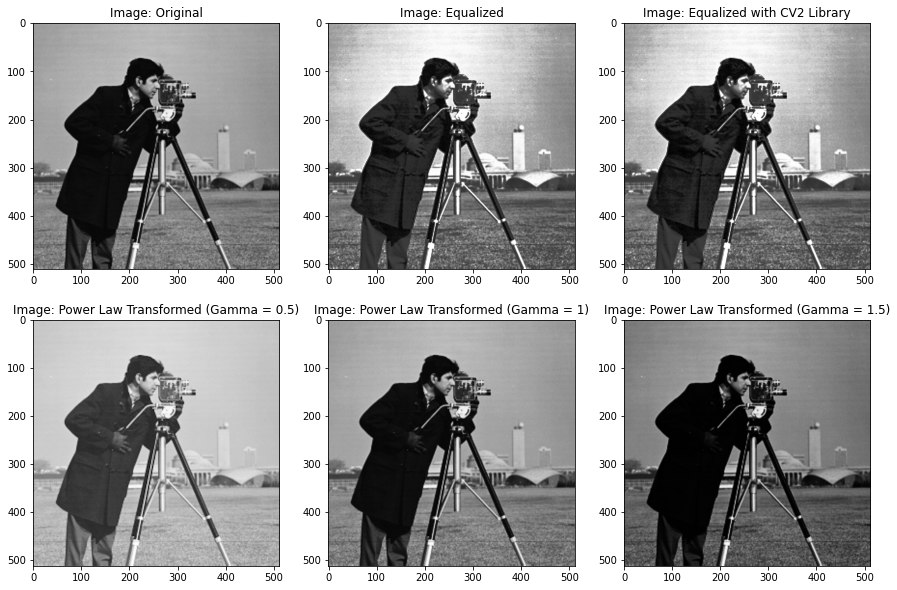

In [ ]:
# 2.1.3
fig, plot = plt.subplots(2, 3, figsize = (15, 10))

plot[0][0].imshow(img, cmap='gray')
plot[0][0].set_title("Image: Original")

equalized = histogram_equalization(img)

plot[0][1].imshow(equalized, cmap='gray')
plot[0][1].set_title("Image: Equalized")

equalized_with_library = cv2.equalizeHist(img)

plot[0][2].imshow(equalized_with_library, cmap='gray')
plot[0][2].set_title("Image: Equalized with CV2 Library")

plot[1][0].imshow(power_law_transform_image_enhancement(img, 0.5), cmap='gray')
plot[1][0].set_title("Image: Power Law Transformed (Gamma = 0.5)")

plot[1][1].imshow(power_law_transform_image_enhancement(img, 1), cmap='gray')
plot[1][1].set_title("Image: Power Law Transformed (Gamma = 1)")

plot[1][2].imshow(power_law_transform_image_enhancement(img, 1.5), cmap='gray')
plot[1][2].set_title("Image: Power Law Transformed (Gamma = 1.5)")

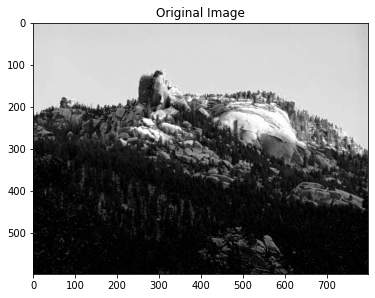

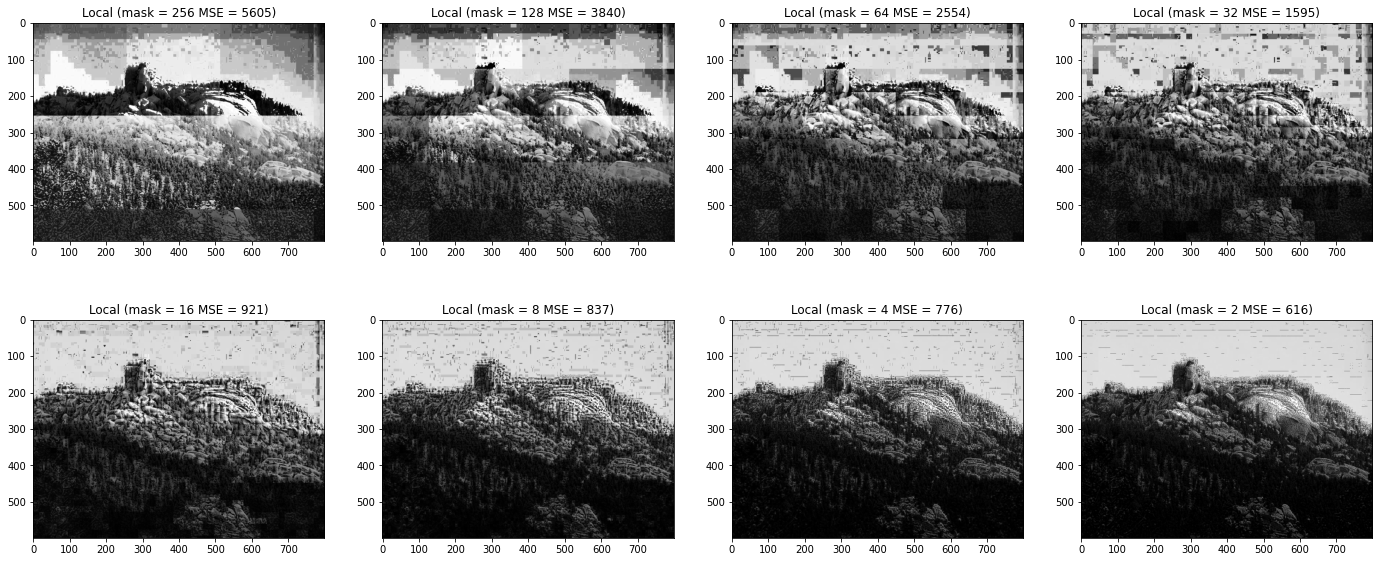

In [ ]:
# 2.2.1
# HE1
img = cv2.imread("HE1.jpg", 0)

fig, plot_r1 = plt.subplots(1, 1, figsize = (6, 5))

plot_r1.imshow(img, cmap='gray')
plot_r1.set_title("Original Image")

fig, plot_r2 = plt.subplots(2, int(len(masks) / 2), figsize = (24, 10))

for mask_index in range (int(len(masks) / 2)):
  for subplot_row in range (2):
    local_equalized = local_histogram_equalization(img, masks[mask_index + 4 * subplot_row], True)

    mse = mean_squared_error(img, local_equalized)

    plot_r2[subplot_row + 0][mask_index].imshow(local_equalized, cmap='gray')
    plot_r2[subplot_row + 0][mask_index].set_title("Local (mask = " + str(masks[mask_index + 4 * subplot_row]) + " MSE = " + str(int(mse)) + ")")

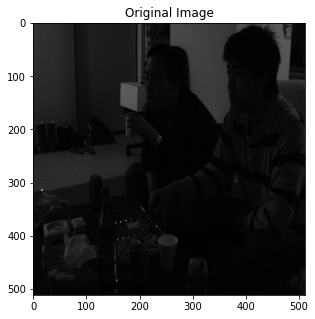

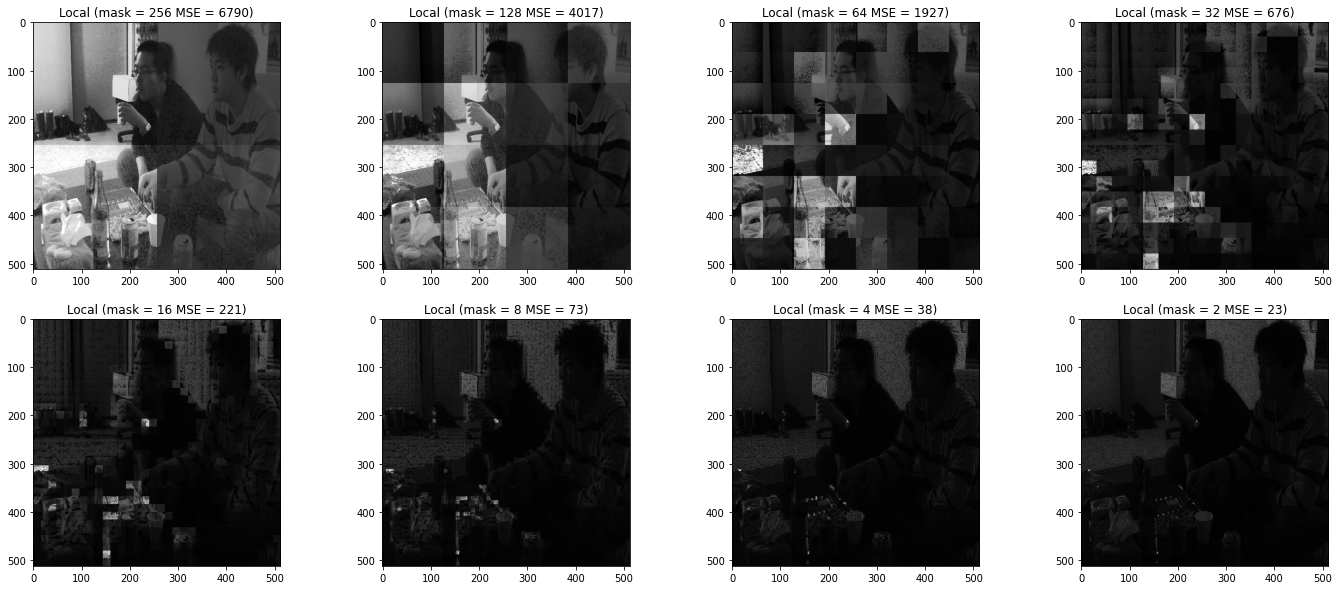

In [ ]:
# 2.2.1
# HE2
img = cv2.imread("HE2.jpg", 0)

fig, plot_r1 = plt.subplots(1, 1, figsize = (6, 5))

plot_r1.imshow(img, cmap='gray')
plot_r1.set_title("Original Image")

fig, plot_r2 = plt.subplots(2, int(len(masks) / 2), figsize = (24, 10))

for mask_index in range (int(len(masks) / 2)):
  for subplot_row in range (2):
    local_equalized = local_histogram_equalization(img, masks[mask_index + 4 * subplot_row], True)

    mse = mean_squared_error(img, local_equalized)

    plot_r2[subplot_row + 0][mask_index].imshow(local_equalized, cmap='gray')
    plot_r2[subplot_row + 0][mask_index].set_title("Local (mask = " + str(masks[mask_index + 4 * subplot_row]) + " MSE = " + str(int(mse)) + ")")

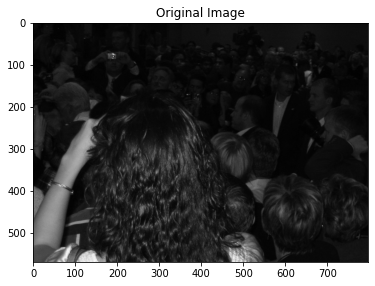

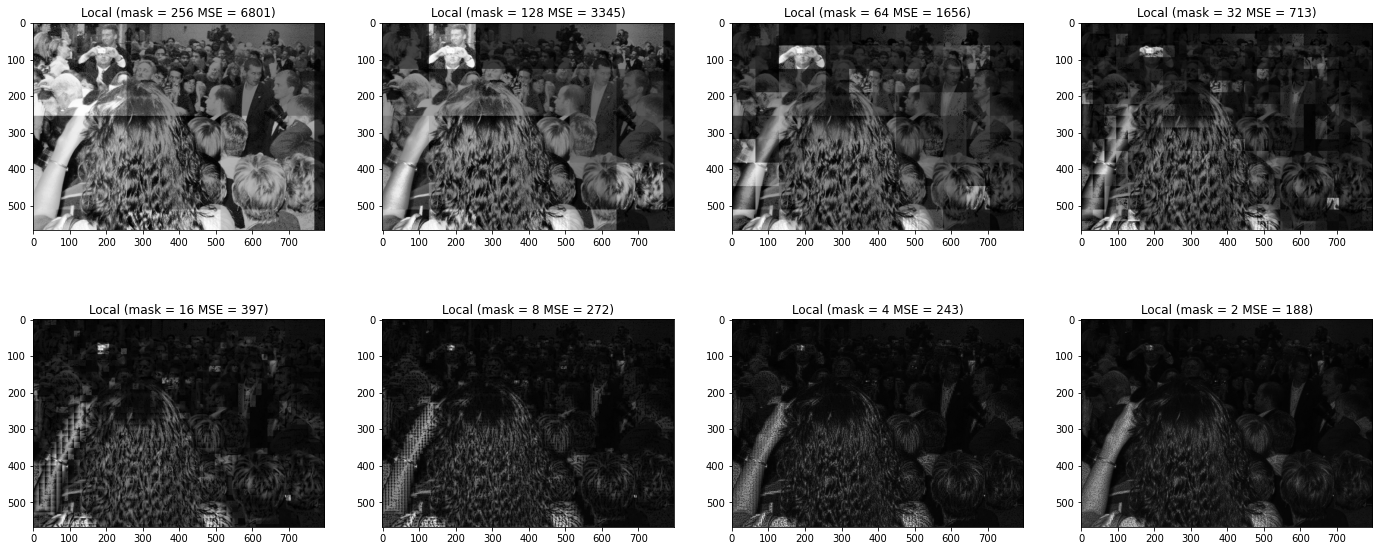

In [ ]:
# 2.2.1
# HE3
img = cv2.imread("HE3.jpg", 0)

fig, plot_r1 = plt.subplots(1, 1, figsize = (6, 5))

plot_r1.imshow(img, cmap='gray')
plot_r1.set_title("Original Image")

fig, plot_r2 = plt.subplots(2, int(len(masks) / 2), figsize = (24, 10))

for mask_index in range (int(len(masks) / 2)):
  for subplot_row in range (2):
    local_equalized = local_histogram_equalization(img, masks[mask_index + 4 * subplot_row], True)

    mse = mean_squared_error(img, local_equalized)

    plot_r2[subplot_row + 0][mask_index].imshow(local_equalized, cmap='gray')
    plot_r2[subplot_row + 0][mask_index].set_title("Local (mask = " + str(masks[mask_index + 4 * subplot_row]) + " MSE = " + str(int(mse)) + ")")

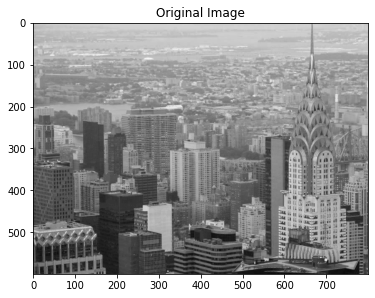

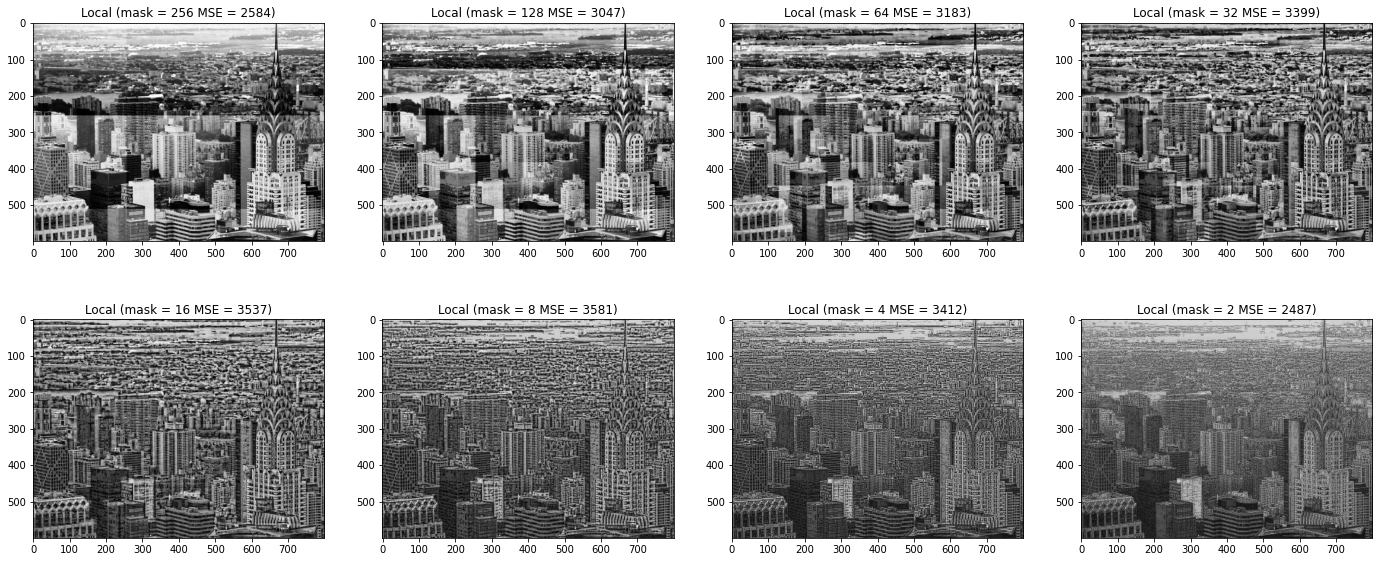

In [ ]:
# 2.2.1
# HE4
img = cv2.imread("HE4.jpg", 0)

fig, plot_r1 = plt.subplots(1, 1, figsize = (6, 5))

plot_r1.imshow(img, cmap='gray')
plot_r1.set_title("Original Image")

fig, plot_r2 = plt.subplots(2, int(len(masks) / 2), figsize = (24, 10))

for mask_index in range (int(len(masks) / 2)):
  for subplot_row in range (2):
    local_equalized = local_histogram_equalization(img, masks[mask_index + 4 * subplot_row], True)

    mse = mean_squared_error(img, local_equalized)

    plot_r2[subplot_row + 0][mask_index].imshow(local_equalized, cmap='gray')
    plot_r2[subplot_row + 0][mask_index].set_title("Local (mask = " + str(masks[mask_index + 4 * subplot_row]) + " MSE = " + str(int(mse)) + ")")